In [1]:
from IPython.display import clear_output
from google.colab import files
files.upload()
#from google.colab import drive
#drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d atulanandjha/lfwpeople
!unzip lfwpeople.zip
!tar -xvzf lfw-funneled.tgz
!rm lfw-funneled.tgz lfwpeople.zip
!pip install -qq tensorflow_addons
clear_output()

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import resnet
from tensorflow.keras.metrics import Mean, CosineSimilarity
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm.notebook import trange, tqdm

from sklearn.model_selection import train_test_split

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    #os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [4]:
IMAGE_SIZE = 105
BATCH_SIZE = 64
epochs = 200
AUTOTUNE = tf.data.AUTOTUNE

**Losses**

In [5]:
# Contrastive Loss showed poor results, so cosine loss taken
def CosineEmbeddingLoss(margin=0.):
    """
    x1 - feature embedding of face one
    x2 - feature embedding of face two
    target - label {-1, 1} - same face or not
    """
    def _cosine_similarity(x1, x2):
        return tf.reduce_sum(x1 * x2, axis=-1) / (tf.norm(x1, axis=-1) * tf.norm(x2, axis=-1))
    def _cosine_embedding_loss_fn(input_one, input_two, target):
        similarity = _cosine_similarity(input_one, input_two)
        return tf.reduce_mean(tf.where(tf.equal(target, 1), 1. - similarity, 
                                       tf.maximum(tf.zeros_like(similarity), similarity - margin)))
    return _cosine_embedding_loss_fn

**Get dataset and split**

In [6]:
img_dir = glob('lfw_funneled/'+'/*/*')
img_dir = [str(x) for x in img_dir]
df = pd.DataFrame(img_dir, columns=['Image_dir'])
df['Name'] = df['Image_dir'].str.split('/', expand=True).loc[:, [1,]]
df.sample(5)

,Image_dir,Name
12149,lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Ma...,Gloria_Macapagal_Arroyo
8355,lfw_funneled/Chuck_Amato/Chuck_Amato_0001.jpg,Chuck_Amato
9040,lfw_funneled/Millicent_Martin/Millicent_Martin...,Millicent_Martin
63,lfw_funneled/Aleksander_Kwasniewski/Aleksander...,Aleksander_Kwasniewski
9311,lfw_funneled/Oscar_Bolanos/Oscar_Bolanos_0001.jpg,Oscar_Bolanos


In [25]:
train, test = train_test_split(df, test_size=600, shuffle=True, random_state=123)
train, valid = train_test_split(train, test_size=1000, shuffle=True, random_state=123)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.shape, valid.shape, test.shape

((11633, 2), (1000, 2), (600, 2))

**Crop face function for preprocessing**

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if len(faces) > 0:
        for x, y, w, h in faces:
            image2 = image[y: y+h, x: x+w, :]
        image2 = cv2.resize(image2, (IMAGE_SIZE, IMAGE_SIZE))
        return image2, 1
    return image, 0

**Advanced image albumentations**

In [9]:
from albumentations import (
    Compose, JpegCompression, HueSaturationValue, HorizontalFlip,
    Rotate, OneOf, ToGray, RandomBrightnessContrast, ElasticTransform, 
    GridDistortion, OpticalDistortion, 
)
from functools import partial

transforms = Compose([OneOf([
                            Rotate(limit=40),
                            ToGray(p=0.5),
                            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
                            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
                            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
                            HorizontalFlip(p=1.),], p=1.0),
                       OneOf([
                             ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                             GridDistortion(p=0.5),
                             OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                            ], p=0.1)
                            ])

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    return aug_img

**Creating iterators**

In [26]:
def get_image(data, idx, prob=0.5, train=False):
    itemA = data.loc[idx, 'Image_dir']
    itemA_name = data.loc[idx, 'Name']
    same_person = np.random.choice([-1,1], p=[prob, 1-prob])
    if same_person == 1:
        itemB_ser = data.loc[(data.Name == itemA_name) & (data.Image_dir != itemA), 'Image_dir']
        itemB_idx = itemB_ser.index
        if len(itemB_idx) >= 1:
            itemB = itemB_ser[np.random.choice(itemB_idx)]
            itemB_name = data.loc[data['Image_dir'] == itemB, 'Name'].values[0]
        else:
            same_person = -1
    if same_person == -1:
        other_persons_idx = data.loc[~(data.Name == itemA_name), :].index
        itemB_row = data.loc[np.random.choice(other_persons_idx)]
        itemB = itemB_row['Image_dir']
        itemB_name = itemB_row['Name']

    imageA = cv2.imread(itemA)
    imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
    imageB = cv2.imread(itemB)
    imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)

    imageA, resultA = crop_face(imageA)
    imageB, resultB = crop_face(imageB)
    if not resultA:
        imageA = cv2.resize(imageA, (IMAGE_SIZE, IMAGE_SIZE))
    if not resultB:
        imageB = cv2.resize(imageB, (IMAGE_SIZE, IMAGE_SIZE))
    
    if train:
        imageA = aug_fn(imageA)
        imageB = aug_fn(imageB)

    imageA = (imageA / 127.5) - 1
    imageB = (imageB / 127.5) - 1

    return imageA, imageB, same_person

def train_data_generator():
    for idx in range(len(train)):
        yield get_image(train, idx, prob=0.4, train=True)

def valid_data_generator():
    for idx in range(len(valid)):
        yield get_image(valid, idx)

def test_data_generator():
    for idx in range(len(test)):
        yield get_image(test, idx)

**TF dataset**

In [11]:
def data_augmentation(image, seed=(1,2)):
    """ inbuilt methods """
    image = tf.image.stateless_random_brightness(image, max_delta=0.95, seed=seed)
    image = tf.image.stateless_random_contrast(image, lower=0.2, upper=0.95, seed=seed)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    image = tf.image.stateless_random_hue(image, max_delta=0.1, seed=seed)
    image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=80, max_jpeg_quality=100, seed=seed)
    image = tf.image.stateless_random_saturation(image, lower=0.8, upper=0.99, seed=seed)
    
    return image

def prepare(generator, shuffle=False):
    ds = tf.data.Dataset.from_generator(generator, 
                                        output_types=(np.float32, np.float32, np.int32),
                                        output_shapes=((IMAGE_SIZE, IMAGE_SIZE, 3), (IMAGE_SIZE, IMAGE_SIZE, 3), None)).cache()
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [27]:
train_ds = prepare(train_data_generator, shuffle=True)
valid_ds = prepare(valid_data_generator)
test_ds = prepare(test_data_generator)

**Model architecture**

In [18]:
class ReflectionPad2D(Layer):
    def __init__(self, paddings=(1,1,1,1)):
        super(ReflectionPad2D, self).__init__()
        self.paddings = paddings

    def call(self, input):
        l, r, t, b = self.paddings

        return tf.pad(input, paddings=[[0,0], [t,b], [l,r], [0,0]], mode='REFLECT')

def convBlock(n_outputs):
    return tf.keras.Sequential([
        tf.keras.layers.Dropout(0.2),
        ReflectionPad2D(),
        tf.keras.layers.Conv2D(n_outputs, kernel_size=3, strides=1, padding="valid", activation="relu"),
        tf.keras.layers.BatchNormalization(),
    ])

class CNNExtractor(tf.keras.Model):
    def __init__(self):
        super(CNNExtractor, self).__init__()
        self.pool = tfa.layers.AdaptiveAveragePooling2D(7)
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
            convBlock(8),
            convBlock(16),
            convBlock(32),
            convBlock(32),
            ])
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10),
            tf.keras.layers.LayerNormalization()  # added in new version
            ])
        # self.build((None,) + (IMAGE_SIZE, IMAGE_SIZE, 3))
        
    def call(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = self.dense(x)
        return x

In [19]:
class SiameseModel(tf.keras.Model):

    def __init__(self):
        super(SiameseModel, self).__init__()
        self.feature_extractor = CNNExtractor()
        self.loss_tracker = Mean(name="loss")
        self.loss_fn = CosineEmbeddingLoss(margin=0.2)
        # self.build((None,) + (IMAGE_SIZE, IMAGE_SIZE, 3))

    def call(self, inputs):
        return self.feature_extractor(inputs)

    def train_step(self, data):
        input1, input2, target = data

        with tf.GradientTape() as tape:
            loss = self._compute_loss(input1, input2, target)

        gradients = tape.gradient(loss, self.feature_extractor.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.feature_extractor.trainable_weights)
            )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        input1, input2, target = data
        loss = self._compute_loss(input1, input2, target)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, input1, input2, target):
        output1 = self.feature_extractor(input1)
        output2 = self.feature_extractor(input2)
        loss = self.loss_fn(output1, output2, target)

        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

**Inint model, training instances and train**

In [28]:
model = SiameseModel()
model.compile(optimizer="adam", weighted_metrics=[])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]

In [31]:
# as training takes too long: process only 5 epochs - model learns enough to demonstrate the approach (initially set 200 epochs)
history = model.fit(train_ds, epochs=25, validation_data=valid_ds, callbacks=callbacks, verbose=1)

Epoch 1/25
182/182 [==============================] - 29s 158ms/step - loss: 0.0288 - val_loss: 0.2102 - lr: 1.0000e-05
Epoch 2/25
182/182 [==============================] - 29s 158ms/step - loss: 0.0277 - val_loss: 0.2103 - lr: 1.0000e-05
Epoch 3/25
182/182 [==============================] - 29s 160ms/step - loss: 0.0271 - val_loss: 0.2109 - lr: 1.0000e-05
Epoch 4/25
182/182 [==============================] - 30s 162ms/step - loss: 0.0266 - val_loss: 0.2111 - lr: 1.0000e-05
Epoch 5/25
182/182 [==============================] - 30s 164ms/step - loss: 0.0260 - val_loss: 0.2112 - lr: 1.0000e-06
Epoch 6/25
182/182 [==============================] - 30s 162ms/step - loss: 0.0259 - val_loss: 0.2112 - lr: 1.0000e-06
Epoch 7/25
182/182 [==============================] - 30s 162ms/step - loss: 0.0258 - val_loss: 0.2113 - lr: 1.0000e-06
Epoch 8/25
182/182 [==============================] - 30s 163ms/step - loss: 0.0257 - val_loss: 0.2113 - lr: 1.0000e-07
Epoch 9/25
182/182 [====================

In [32]:
model.evaluate(test_ds)

10/10 [==============================] - 43s 4s/step - loss: 0.1988


0.1988101750612259

**Save model**

In [ ]:
# save method do not work
path = '/content/drive/My Drive/data/ce_model'
model.save_weights(path)
symbolic_weights = getattr(model.optimizer, 'weights')
weight_values = K.batch_get_value(symbolic_weights)
with open(path+'optimizer.pkl', 'wb') as f:
    pickle.dump(weight_values, f)

In [ ]:
model = SiameseModel()
model.compile(optimizer="adam", weighted_metrics=[])
path = '/content/drive/My Drive/data/ce_model'

model.load_weights(path)
with open(path+'optimizer.pkl', 'rb') as f:
    weight_values = pickle.load(f)
model.optimizer.set_weights(weight_values)

**Inference**

In [ ]:
im1, im2, gt = get_image(test, 18)
out1 = model.predict(im1[None, ...], verbose=0)
out2 = model.predict(im2[None, ...], verbose=0)
similarity = CosineSimilarity()(out1, out2)

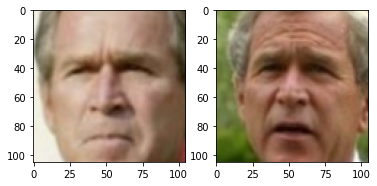

Same 0.8441779017448425 truth: 1


In [ ]:
plt.subplot(121)
plt.imshow(((im1+1)*127.5).astype(np.uint8))
plt.subplot(122)
plt.imshow(((im2+1)*127.5).astype(np.uint8))
plt.show()
out_string = "Same" if similarity >= 0.5 else "Different"
print(out_string, similarity.numpy().item(), f"truth: {gt}")

In [33]:
acc = 0
for i in trange(len(test)):
    im1, im2, gt = get_image(test, i)
    out1 = model.predict(im1[None, ...], verbose=0)
    out2 = model.predict(im2[None, ...], verbose=0)
    similarity = CosineSimilarity()(out1, out2)
    label = 1 if similarity >= 0.5 else -1
    if label == gt:
        acc += 1

print(f"Accuracy: {acc/len(test):.4f}")

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 0.7400
